In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing Data
df = pd.read_csv('../Data/address_data_combined.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import time

logreg = LogisticRegression()
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',        # metric for scoring
                   cv=10)                     # number of folds
start_time = time.time()
clf.fit(X_train_full ,y_train_full)
print(time.time() - start_time)

84.84941697120667


In [9]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Train F1 Score :",clf.best_score_)
best_y_pr = clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Train F1 Score : 0.8356396198887012
Test F1 Score:  0.8360406091370559


In [4]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
logreg = LogisticRegression(C=1000,penalty="l1",solver='liblinear')
logreg.fit(X_train_full,y_train_full)
y_pred = logreg.predict(X_test)
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))


0.8360406091370559
0.8474636012350274
0.8420245398773006
0.8478926300918296
0.8301411290322581


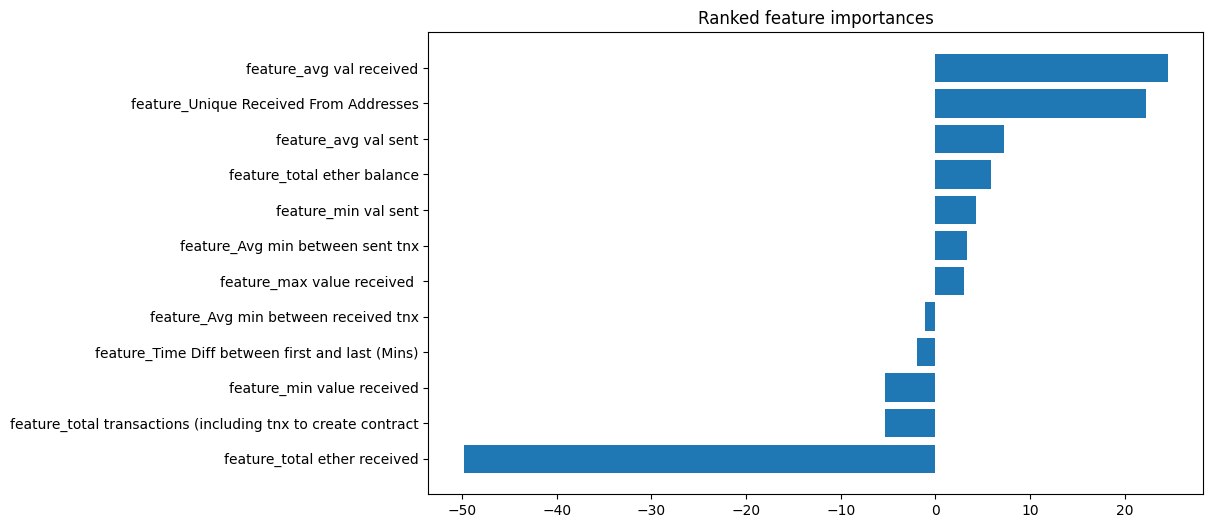

In [5]:
feat_importances = clf.best_estimator_.coef_[0]
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();